In [1]:
!pip install numpy pandas yfinance tensorflow matplotlib scikit-learn streamlit


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime


In [5]:
# Load the pre-trained LSTM model for stock predictions
model = load_model(r"C:\Users\behra\Downloads\stock market\Stock Predictions Model.keras")


In [7]:
# Set the stock symbol to a desired value (e.g., 'GOOG' for Google stock)
stock = 'GOOG'  # Replace 'GOOG' with any stock symbol you wish to analyze


In [9]:
# Set the date range for stock data (last 20 years)
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)

# Fetch historical stock data from Yahoo Finance
data = yf.download(stock, start, end)


[*********************100%***********************]  1 of 1 completed


In [11]:
# Display the fetched stock data
print(data)


Price                       Adj Close       Close        High         Low  \
Ticker                           GOOG        GOOG        GOOG        GOOG   
Date                                                                        
2004-11-15 00:00:00+00:00    4.593211    4.604491    4.690419    4.452063   
2004-11-16 00:00:00+00:00    4.286864    4.297392    4.469995    4.254802   
2004-11-17 00:00:00+00:00    4.285871    4.296396    4.420929    4.209223   
2004-11-18 00:00:00+00:00    4.162636    4.172859    4.344217    4.127778   
2004-11-19 00:00:00+00:00    4.208849    4.219185    4.233631    4.147454   
...                               ...         ...         ...         ...   
2024-11-08 00:00:00+00:00  179.860001  179.860001  182.350006  179.570007   
2024-11-11 00:00:00+00:00  181.970001  181.970001  182.085007  179.990005   
2024-11-12 00:00:00+00:00  183.320007  183.320007  184.024994  180.990005   
2024-11-13 00:00:00+00:00  180.490005  180.490005  182.615005  180.119995   

In [13]:
# Split data into training and testing sets (80% training, 20% testing)
data_train = pd.DataFrame(data['Close'][0:int(len(data) * 0.80)])
data_test = pd.DataFrame(data['Close'][int(len(data) * 0.80):])


In [15]:
# Scale the data between 0 and 1 for LSTM input
scaler = MinMaxScaler(feature_range=(0, 1))

# Get the last 100 days from the training set and combine it with the test set for prediction
past_100_days = data_train.tail(100)
data_test_combined = pd.concat([past_100_days, data_test], ignore_index=True)
data_test_scaled = scaler.fit_transform(data_test_combined)


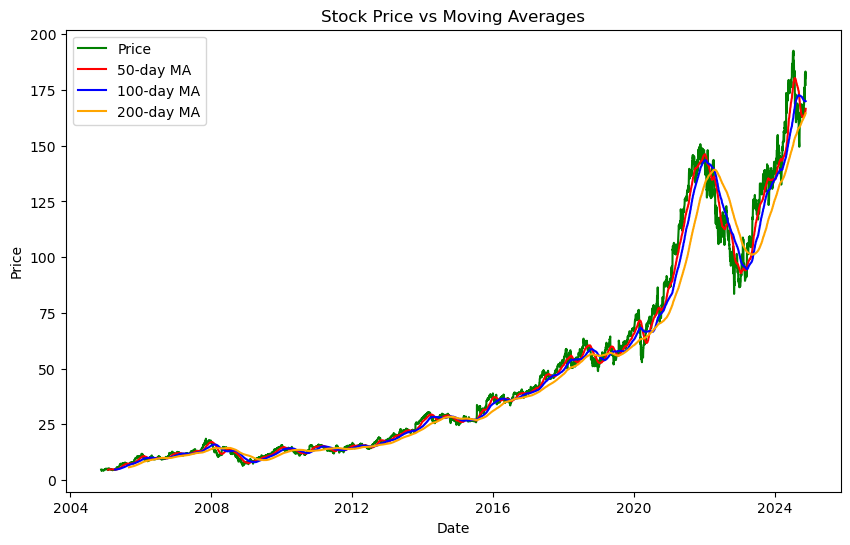

In [17]:
# Calculate moving averages (50-day, 100-day, 200-day)
ma_50 = data['Close'].rolling(window=50).mean()
ma_100 = data['Close'].rolling(window=100).mean()
ma_200 = data['Close'].rolling(window=200).mean()

# Plot stock price vs moving averages
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Price', color='green')
plt.plot(ma_50, label='50-day MA', color='red')
plt.plot(ma_100, label='100-day MA', color='blue')
plt.plot(ma_200, label='200-day MA', color='orange')
plt.title('Stock Price vs Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [19]:
# Prepare the data for LSTM model input (last 100 days)
X_test, y_test = [], []
for i in range(100, data_test_scaled.shape[0]):
    X_test.append(data_test_scaled[i-100:i])
    y_test.append(data_test_scaled[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)


In [21]:
# Predict stock prices using the loaded model
predictions = model.predict(X_test)

# Rescale the predictions back to original prices
scale_factor = 1 / scaler.scale_[0]
predictions_rescaled = predictions * scale_factor
y_test_rescaled = y_test * scale_factor


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


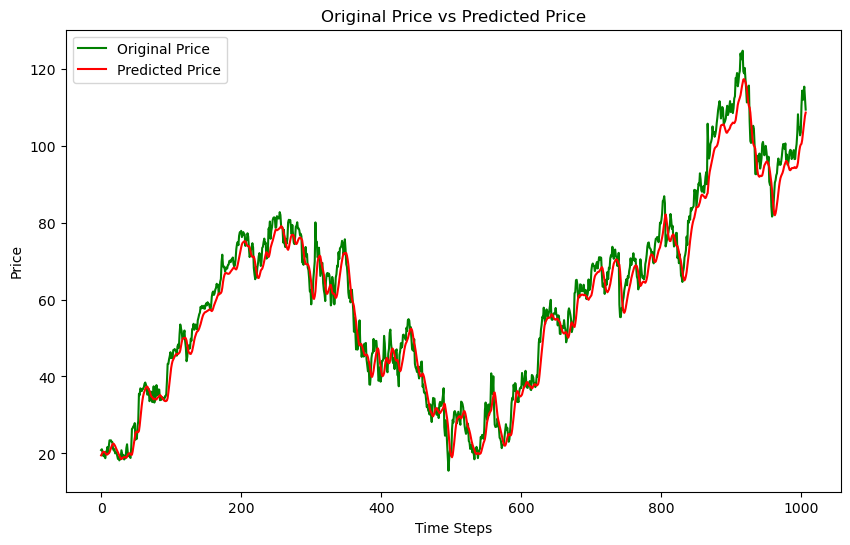

In [23]:
# Plot original price vs predicted price
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Original Price', color='green')
plt.plot(predictions_rescaled, label='Predicted Price', color='red')
plt.title('Original Price vs Predicted Price')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()


In [27]:
# Predict future prices for the next 504 days (about 2 years)
future_predictions = []
last_sequence = data_test_scaled[-100:]
last_sequence = np.reshape(last_sequence, (1, last_sequence.shape[0], 1))

for _ in range(504):
    next_pred = model.predict(last_sequence)[0][0]
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[:, 1:, :], np.reshape([[next_pred]], (1, 1, 1)), axis=1)

# Rescale future predictions back to original prices
future_predictions_rescaled = np.array(future_predictions) * scale_factor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

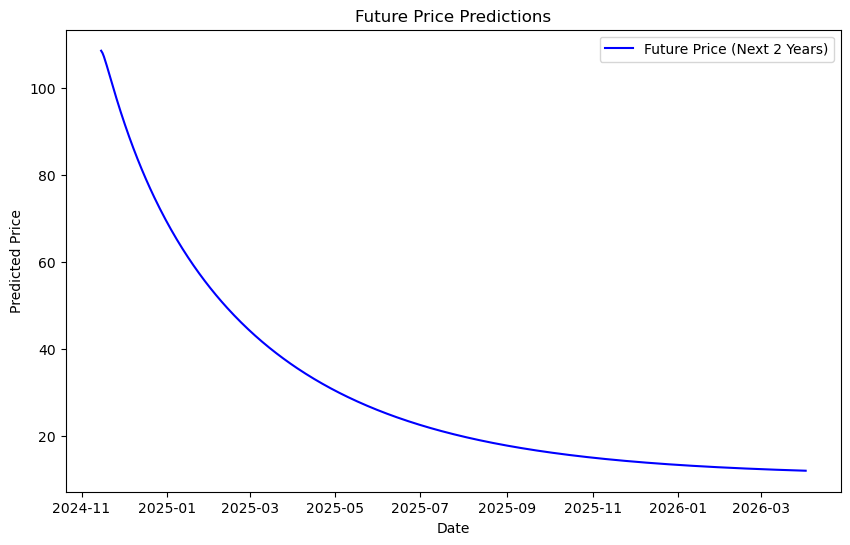

In [29]:
# Generate future dates and plot future predictions
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=504)

plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_predictions_rescaled, label='Future Price (Next 2 Years)', color='blue')
plt.title('Future Price Predictions')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()
